# Unit 3 final project
## Arutyunyan Vitaly (DST-46)


# import

In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Загружаем инструменты для категориальных признаков
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [29]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 56

In [30]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [31]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [32]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [33]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [35]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
11604,id_3844,London,['Cafe'],3851.0,$,68.0,"[['Lovely', 'Just what we needed'], ['07/25/20...",/Restaurant_Review-g186338-d2437398-Reviews-Bi...,d2437398,1,4.5
1821,id_1821,Milan,NaN,3363.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187849-d10027603-Reviews-P...,d10027603,0,0.0
1201,id_1201,Athens,NaN,1107.0,NaN,NaN,"[[], []]",/Restaurant_Review-g189400-d12550266-Reviews-Z...,d12550266,0,0.0
14639,id_3359,Milan,['Italian'],3361.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187849-d4782938-Reviews-BI...,d4782938,1,5.0
32265,id_8451,Paris,"['French', 'Cafe']",8453.0,NaN,8.0,"[[], []]",/Restaurant_Review-g187147-d6363928-Reviews-L_...,d6363928,1,4.5


In [12]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

## Очистка и подготовка данных

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [36]:
# Для примера я возьму столбец Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [ ]:
#data['Number_of_Reviews_isNAN']

In [37]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
data['Number of Reviews'].fillna(0, inplace=True)

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [38]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
dtype: int64

### (new) Country

In [39]:
countries_dict = {
    'London': 'England',
    'Paris': 'France',
    'Madrid': 'Spain',
    'Barcelona': 'Spain',
    'Berlin': 'Germany',
    'Milan': 'Italy',
    'Rome': 'Italy',
    'Prague': 'Czech',
    'Lisbon': 'Portugal',
    'Vienna': 'Austria',
    'Amsterdam': 'Holland',
    'Brussels': 'Belgium',
    'Hamburg': 'Germany',
    'Munich': 'Germany',
    'Lyon': 'France',
    'Stockholm': 'Sweden',
    'Budapest': 'Romania',
    'Warsaw': 'Poland',
    'Dublin': 'Ireland',
    'Copenhagen': 'Denmark',
    'Athens': 'Greece',
    'Edinburgh': 'Scotland',
    'Zurich': 'Switzerland',
    'Oporto': 'Portugal',
    'Geneva': 'Switzerland',
    'Krakow': 'Poland',
    'Oslo': 'Norway',
    'Helsinki': 'Finland',
    'Bratislava': 'Slovakia',
    'Luxembourg': 'Luxembourg',
    'Ljubljana': 'Slovenia'
}
data['Country'] = data['City'].map(countries_dict)

countries_labels = LabelEncoder()
countries_labels.fit(data['Country'])
data['country code'] = countries_labels.transform(data['Country'])

### (new) Capital city (является ли город столицей)

In [40]:
is_capital = {
    'London': 1,
    'Paris' : 1,
    'Madrid': 1,
    'Barcelona': 0,
    'Berlin': 1,
    'Milan': 0,
    'Rome': 1,
    'Prague': 1,
    'Lisbon': 1,
    'Vienna': 1,
    'Amsterdam': 1,
    'Brussels': 1,
    'Hamburg': 0,
    'Munich': 0,
    'Lyon': 0,
    'Stockholm': 1,
    'Budapest': 1,
    'Warsaw': 1,
    'Dublin': 1,
    'Copenhagen': 1,
    'Athens': 1,
    'Edinburgh': 1,
    'Zurich': 1,
    'Oporto': 0,
    'Geneva': 1,
    'Krakow': 0,
    'Oslo': 1,
    'Helsinki': 1,
    'Bratislava': 1,
    'Luxembourg': 1,
    'Ljubljana': 1
}

data['is capital'] = data['City'].map(is_capital)

### (new) Population of city

In [41]:
population = {
    'London': 8908081,
    'Paris' : 2148327,
    'Madrid': 3223334,
    'Barcelona': 1620343,
    'Berlin': 3769495,
    'Milan': 1378689,
    'Rome': 2870500,
    'Prague': 1324277,
    'Lisbon': 505526,
    'Vienna': 1897491,
    'Amsterdam': 857713,
    'Brussels': 179277,
    'Hamburg': 1899160,
    'Munich': 1471508,
    'Lyon': 513275,
    'Stockholm': 975904,
    'Budapest': 1752286,
    'Warsaw': 1790658,
    'Dublin': 554554,
    'Copenhagen': 794128,
    'Athens': 664046,
    'Edinburgh': 488100,
    'Zurich': 415215,
    'Oporto': 214349,
    'Geneva': 201818,
    'Krakow': 769498,
    'Oslo': 681067,
    'Helsinki': 650058,
    'Bratislava': 437725,
    'Luxembourg': 613894,
    'Ljubljana': 284355
}
data['population of city'] = data['City'].map(population)

### (new) Count restaurants in city

In [42]:
r_count = data.groupby('City')['Restaurant_id'].count().to_dict()
# print(r_count)
data['Count rest in city'] = data['City'].map(r_count)

### (new) Relative ranking

In [43]:
data['ralative ranking'] = data['Ranking'] / data['Count rest in city']

### (new) Population on restaurant

In [44]:
data['population_on_rest'] = data['population of city'] / data['Count rest in city']

In [45]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Country,country code,is capital,population of city,Count rest in city,ralative ranking,population_on_rest
20041,id_7214,Madrid,NaN,7219.0,NaN,31.0,"[['A decent dinner.', 'Nice Italian restaurant...",/Restaurant_Review-g187514-d5444916-Reviews-O_...,d5444916,1,3.0,0,Spain,20,1,3223334,3813,1.893260,845.353790
32887,id_8403,Paris,['Indian'],8405.0,$$ - $$$,33.0,"[['Live Music', 'Great food, great service'], ...",/Restaurant_Review-g187147-d2170739-Reviews-Ga...,d2170739,1,4.0,0,France,6,1,2148327,6108,1.376064,351.723477
16192,id_8423,Paris,['French'],8425.0,$$ - $$$,21.0,"[['Eh oui, we will return', 'Excellent place f...",/Restaurant_Review-g187147-d3678414-Reviews-EH...,d3678414,1,4.5,0,France,6,1,2148327,6108,1.379339,351.723477
39526,id_734,Lyon,NaN,735.0,NaN,47.0,"[[], []]",/Restaurant_Review-g187265-d1974266-Reviews-Pi...,d1974266,1,4.0,0,France,6,0,513275,1126,0.652753,455.839254
17396,id_553,Berlin,"['European', 'Vegetarian Friendly', 'Vegan Opt...",554.0,$$ - $$$,197.0,"[['Great ambiance', 'Great, well presented foo...",/Restaurant_Review-g187323-d1946172-Reviews-Mi...,d1946172,1,4.0,0,Germany,7,1,3769495,2705,0.204806,1393.528651


In [46]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [47]:
data.head(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,id_0,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
16041,id_363,"['International', 'European', 'Czech', 'Vegeta...",364.0,$$$$,78.0,[['Amazing wine and food in a beautiful place'...,/Restaurant_Review-g274707-d6827857-Reviews-Sa...,d6827857,1,4.5,...,0,0,0,1,0,0,0,0,0,0
4385,id_4385,"['Italian', 'Mediterranean', 'European', 'Cent...",617.0,$$ - $$$,240.0,"[['trendy but less than average food', 'Nice B...",/Restaurant_Review-g187309-d4086802-Reviews-EL...,d4086802,0,0.0,...,0,0,0,0,0,0,0,0,0,0
14685,id_570,"['Irish', 'Bar', 'Pub', 'European']",571.0,$$ - $$$,155.0,"[['Traditional pub run by a charming family', ...",/Restaurant_Review-g186605-d1837927-Reviews-Oi...,d1837927,1,4.0,...,0,0,0,0,0,0,0,0,0,0
23460,id_8752,"['Bar', 'Cafe', 'Spanish', 'Pub']",8762.0,NaN,0.0,"[[], []]",/Restaurant_Review-g187514-d13074167-Reviews-V...,d13074167,1,1.0,...,0,0,0,0,0,0,0,0,0,0
3027,id_3027,"['Indian', 'Vegan Options', 'Vegetarian Friend...",27.0,$$ - $$$,280.0,"[['Authentic Indian Restaurant', 'True indian ...",/Restaurant_Review-g189400-d10374870-Reviews-R...,d10374870,0,0.0,...,0,0,0,0,0,0,0,0,0,0


### Cuisine Style

In [49]:
# Признак имеет 23.18% пропусков
# сохраним эту информацию
data['NaN_Cuisine Style'] = pd.isna(data['Cuisine Style']).astype('float64')

# Можно закполнить пропуски значением 'Empty'
data['Cuisine Style'] = data['Cuisine Style'].fillna("['Empty']")



### Price Range

In [50]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [51]:
# Обработка 'Price Range'
# сохранение информации о пропусках, чтобы не потерять
data['NaN_Price_Range'] = pd.isna(data['Price Range']).astype('float64')

# В признаке очень много пропусков 34.7%
# Заполним эти пропуски значением $$ - $$$
data['Price Range'] = data['Price Range'].fillna('$$ - $$$')

# Признак Price Range можно перевести в числовой вид
price_values_dict = {
    '$': 1,
    '$$ - $$$': 2,
    '$$$$': 3
}
data['Price Range'] = data['Price Range'].map(lambda x: price_values_dict.get(x, x))

In [52]:
data['Price Range'].value_counts()

2    40402
1     7816
3     1782
Name: Price Range, dtype: int64

### Number of Reviews

In [53]:
# В признаке 6.4% пропущенных значений
# сохраним эту информацию
data['NaN_Number of reviews'] = pd.isna(data['Number of Reviews']).astype('float64')



In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 53 columns):
Restaurant_id              50000 non-null object
Cuisine Style              50000 non-null object
Ranking                    50000 non-null float64
Price Range                50000 non-null int64
Number of Reviews          50000 non-null float64
Reviews                    49998 non-null object
URL_TA                     50000 non-null object
ID_TA                      50000 non-null object
sample                     50000 non-null int64
Rating                     50000 non-null float64
Number_of_Reviews_isNAN    50000 non-null uint8
Country                    50000 non-null object
country code               50000 non-null int64
is capital                 50000 non-null int64
population of city         50000 non-null int64
Count rest in city         50000 non-null int64
ralative ranking           50000 non-null float64
population_on_rest         50000 non-null float64
City_Amster

In [55]:
data.sample(7)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,NaN_Cuisine Style,NaN_Price_Range,NaN_Number of reviews
44370,id_6730,"['Asian', 'Thai', 'Chinese']",6731.0,2,107.0,"[['Good place for buffet', 'Nothing was less t...",/Restaurant_Review-g187147-d782247-Reviews-Le_...,d782247,1,4.0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
10618,id_528,"['Asian', 'Vegetarian Friendly', 'Vegan Options']",529.0,2,97.0,"[['Fine Bao Burgers in Berlin!', 'Burgers with...",/Restaurant_Review-g187323-d7905491-Reviews-Bu...,d7905491,1,4.0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
13963,id_1635,['Empty'],1638.0,2,3.0,"[['Cheap Asiatic Takeaway'], ['12/01/2016']]",/Restaurant_Review-g187331-d11880466-Reviews-N...,d11880466,1,4.5,...,0,0,0,0,0,0,0,1.0,1.0,0.0
25252,id_2729,['Indian'],2736.0,2,0.0,"[['Really nice meal'], ['10/19/2017']]",/Restaurant_Review-g188590-d12977991-Reviews-I...,d12977991,1,4.0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
34115,id_9865,"['French', 'European']",9867.0,2,113.0,"[['Friendly place with tasty food', 'One of th...",/Restaurant_Review-g187147-d1478636-Reviews-38...,d1478636,1,3.5,...,0,0,0,0,0,0,0,0.0,0.0,0.0
5507,id_5507,"['American', 'Bar', 'Pub', 'International']",3520.0,2,155.0,"[['Made to feel very welcome', 'Very nice plac...",/Restaurant_Review-g187147-d3327836-Reviews-Pl...,d3327836,0,0.0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
4958,id_4958,"['Italian', 'Pizza']",721.0,1,27.0,"[['Great pizzas', 'Delicious pizzas'], ['08/17...",/Restaurant_Review-g189541-d1180871-Reviews-Le...,d1180871,0,0.0,...,0,0,0,0,0,0,0,0.0,0.0,0.0


### --

In [56]:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

df_preproc = data
df_preproc.sample(10)

,Ranking,Price Range,Number of Reviews,sample,Rating,Number_of_Reviews_isNAN,country code,is capital,population of city,Count rest in city,...,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,NaN_Cuisine Style,NaN_Price_Range,NaN_Number of reviews
9452,374.0,2,708.0,0,0.0,0,15,1,505526,1647,...,0,0,0,0,0,0,0,0.0,0.0,0.0
19983,866.0,2,115.0,1,3.5,0,21,1,975904,1033,...,0,0,1,0,0,0,0,0.0,0.0,0.0
24173,5006.0,1,83.0,1,4.5,0,4,1,8908081,7193,...,0,0,0,0,0,0,0,0.0,0.0,0.0
3609,7548.0,2,38.0,0,0.0,0,4,1,8908081,7193,...,0,0,0,0,0,0,0,0.0,0.0,0.0
20939,2038.0,1,96.0,1,4.5,0,6,1,2148327,6108,...,0,0,0,0,0,0,0,0.0,0.0,0.0
6897,782.0,2,0.0,0,0.0,1,18,1,437725,380,...,0,0,0,0,0,0,0,0.0,1.0,0.0
37056,2261.0,2,33.0,1,3.0,0,21,1,975904,1033,...,0,0,1,0,0,0,0,0.0,0.0,0.0
22208,4499.0,3,157.0,1,4.0,0,6,1,2148327,6108,...,0,0,0,0,0,0,0,0.0,0.0,0.0
40773,6645.0,2,7.0,1,3.5,0,20,1,3223334,3813,...,0,0,0,0,0,0,0,1.0,1.0,0.0
14606,11576.0,2,4.0,1,4.0,0,6,1,2148327,6108,...,0,0,0,0,0,0,0,0.0,1.0,0.0


In [57]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [58]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [59]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 46), (40000, 46), (40000, 45), (32000, 45), (8000, 45))

In [60]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [61]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [62]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.0s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=56, verbose=1,
                      warm_start=False)

In [63]:
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
def rating_round(x, base=0.5):
    return base * round(x/base)

def predict(ds):
    return np.array([rating_round(x) for x in model.predict(ds)])

y_pred = predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [64]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.182375


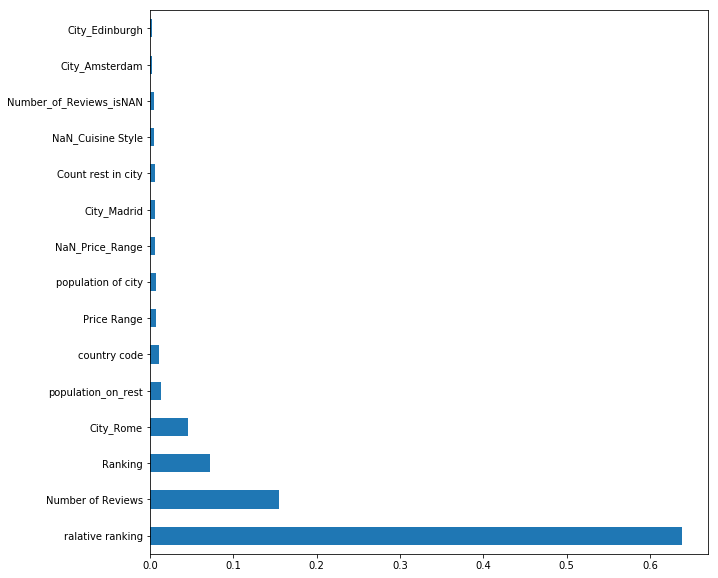

In [65]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [66]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,Number_of_Reviews_isNAN,country code,is capital,population of city,Count rest in city,ralative ranking,...,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,NaN_Cuisine Style,NaN_Price_Range,NaN_Number of reviews
7090,1386.0,2,9.0,0.0,0,22,1,201818,590,2.349153,...,0,0,0,0,0,0,0,1.0,1.0,0.0
946,912.0,3,2.0,0.0,0,22,1,415215,685,1.331387,...,0,0,0,0,0,1,0,0.0,0.0,0.0
4293,775.0,2,4.0,0.0,0,5,1,650058,475,1.631579,...,0,0,0,0,0,0,0,0.0,1.0,0.0
5800,3617.0,1,6.0,0.0,0,2,1,1324277,1816,1.991740,...,1,0,0,0,0,0,0,0.0,0.0,0.0
1886,3025.0,2,22.0,0.0,0,6,1,2148327,6108,0.495252,...,0,0,0,0,0,0,0,0.0,0.0,0.0
1686,607.0,2,36.0,0.0,0,10,1,554554,836,0.726077,...,0,0,0,0,0,0,0,0.0,1.0,0.0
4625,2589.0,2,218.0,0.0,0,4,1,8908081,7193,0.359933,...,0,0,0,0,0,0,0,0.0,0.0,0.0
3251,3434.0,2,65.0,0.0,0,6,1,2148327,6108,0.562213,...,0,0,0,0,0,0,0,1.0,1.0,0.0
3887,540.0,2,807.0,0.0,0,6,0,513275,1126,0.479574,...,0,0,0,0,0,0,0,0.0,0.0,0.0
2287,6080.0,2,5.0,0.0,0,20,1,3223334,3813,1.594545,...,0,0,0,0,0,0,0,1.0,1.0,0.0


In [67]:
test_data = test_data.drop(['Rating'], axis=1)

In [68]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [69]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [70]:
predict_submission

array([3.285, 4.185, 4.53 , ..., 3.015, 4.205, 4.33 ])

In [71]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.285
1,id_1,4.185
2,id_2,4.530
3,id_3,4.340
4,id_4,4.490
5,id_5,4.620
6,id_6,1.650
7,id_7,3.190
8,id_8,4.165
9,id_9,4.610


### --

############################
############################
############################

####################################################################

###############################################################

### Посмотрим распределение признака

In [ ]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

In [ ]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

In [ ]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

In [ ]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

In [ ]:
data.groupby(['City'])['Ranking'].mean()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

In [ ]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

In [ ]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

In [ ]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

In [ ]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [ ]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

In [ ]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [ ]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

In [ ]:
df_preproc.info()

In [ ]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

# Model 
Сам ML

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [ ]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['Rating'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
